# Investigating Baseball Salaries

In [1]:
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns
import statsmodels.api as sm

from matplotlib.colors import ListedColormap

%matplotlib notebook

## Introduction

It is easy to come up with several reasonable expectations about the relationship between a player's salary and some construct. For example, one might expect that successful players will receive higher salaries. But do these reasonable expectations always hold? In this analysis, we search for an answer to the broad question: What is the relationship between salary and success?

One can measure success in several ways, depending, for example, on how broadly one restricts one's view. In this analysis, we will study success at two levels&mdash;team and player. One can also approach, for each level, the question of success from many angles. We will devote our attention to just a few.

In [2]:
project_dir = 'Q:\\Program Files\\Programming Applications\\Projects\\Udacity\\Data Analysis Nanodegree\\P2\\'

ave_infl = pd.read_table(project_dir + 'inflation.txt', usecols=['YEAR', 'AVE'])
ave_infl = ave_infl.set_index(ave_infl['YEAR'].astype(int))
ave_infl = ave_infl.ix[1986:, 'AVE']/100

def year_to_rate(year):
    ret_rate = 1
    
    if year != 2015:
        for rate in ave_infl.loc[(year + 1):]:
                ret_rate *= (1 + rate)
    
    return ret_rate

salaries = pd.read_csv(project_dir + 'baseball_data\\Salaries.csv')
## the first component of the product maps a particulr year to its respective inflation rate
salaries['salary'] = salaries['yearID'].apply(year_to_rate) * salaries['salary']

Notice that we modified the salary entries a bit. Before, each salary entry was listed nominally according to the year that it was recorded. Thus, we adjust all salaries for inflation, so that their value represents their worth in 2015. Information from inflation.txt was scrapped from the table provided [here](http://www.usinflationcalculator.com/inflation/historical-inflation-rates/). All values from that table come from the [monthly CPI publication](https://www.bls.gov/cpi/home.htm) by the Bureau of Labor Statistics.

**REMARK**: since 'salaries' starts in 1985, we must exclude all prior entries for all other datasets. 

## Team-level success
### Data wrangling

In [3]:
teams = pd.read_csv(
    project_dir + 'baseball_data\\Teams.csv',
    dtype={
        'yearID': int,
        'Rank': int, 
        'G': int, 
        'W': int, 
        'L': int
    },
    usecols=[
        'yearID', 
        'lgID', 
        'teamID', 
        'Rank', 
        'G', 
        'W', 
        'L',
        'DivWin', 
        'WCWin', 
        'LgWin', 
        'WSWin',
        'name', 
    ]
)

teams = teams.loc[teams['yearID'] >= 1985, :]

teams['DivWin'] = teams['DivWin'] == 'Y'
teams['WCWin'] = teams['WCWin'] == 'Y'
teams['LgWin'] = teams['LgWin'] == 'Y'
teams['WSWin'] = teams['WSWin'] == 'Y'

In [4]:
teams.shape

(888, 12)

I invoke team's shape attribute so as to have an expected dimension for the cleaned up dataset (called data). 

In [5]:
salaries_grouped = salaries.groupby(['yearID', 'lgID', 'teamID'])

yr_lg_tm_med_sal = {g[0]: g[1]['salary'].median() for g in salaries_grouped}
yr_lg_tm_med_sal = pd.Series(yr_lg_tm_med_sal, name='median_salary')

yr_lg_tm_med_sal.index = yr_lg_tm_med_sal.index.set_names(['yearID', 'lgID', 'teamID'])
yr_lg_tm_med_sal = yr_lg_tm_med_sal.sort_index()

group_by_list = ['yearID', 'lgID']
teams_grouped = teams.groupby(group_by_list)
columns = [col for col in teams.columns if col not in group_by_list and col != 'teamID']

yr_lg_tm_teams = {}
for g in teams_grouped:
    yr_lg_tm_teams[g[0]] = g[1].set_index('teamID')[columns]
    
yr_lg_tm_teams = pd.concat(yr_lg_tm_teams)
yr_lg_tm_teams.index = yr_lg_tm_teams.index.set_names(['yearID', 'lgID', 'teamID'])
yr_lg_tm_teams = yr_lg_tm_teams.sort_index()

data = pd.concat([yr_lg_tm_teams, yr_lg_tm_med_sal], axis=1)

In [6]:
data.shape

(890, 10)

Hm. Something must be wrong.

In [7]:
data.loc[data.isnull().any(axis=1), :]

,,,Rank,G,W,L,DivWin,WCWin,LgWin,WSWin,name,median_salary
yearID,lgID,teamID,,,,,,,,,,
2014,NL,CLE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4504500.0
2015,AL,ARI,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4875000.0


There are 2 more rows than there should be, so my guess is that these NaN rows are the location of the issue.

In [8]:
idx = pd.IndexSlice

data.loc[idx[2014:2016, :, ['CLE', 'ARI']], :]

Rank      G     W     L DivWin  WCWin  LgWin  WSWin  \
yearID lgID teamID                                                        
2014   AL   CLE      3.0  162.0  85.0  77.0  False  False  False  False   
       NL   ARI      5.0  162.0  64.0  98.0  False  False  False  False   
            CLE      NaN    NaN   NaN   NaN    NaN    NaN    NaN    NaN   
2015   AL   ARI      NaN    NaN   NaN   NaN    NaN    NaN    NaN    NaN   
            CLE      3.0  161.0  81.0  80.0  False  False  False  False   
       NL   ARI      3.0  162.0  79.0  83.0  False  False  False  False   

                                    name  median_salary  
yearID lgID teamID                                       
2014   AL   CLE        Cleveland Indians    1184516.333  
       NL   ARI     Arizona Diamondbacks    2064562.500  
            CLE                      NaN    4504500.000  
2015   AL   ARI                      NaN    4875000.000  
            CLE        Cleveland Indians    1550000.000  
       NL   ARI     Arizona Diamondbacks     700000.000

It seems that those teams have mislabeled league IDs. For good measure, let's cross-reference these rows with the salaries datset: maybe there's another reason for this occurence.

In [9]:
search_index = (
    ((salaries['yearID'] == 2014) & (salaries['lgID'] == 'NL') & (salaries['teamID'] == 'CLE')) | 
    ((salaries['yearID'] == 2015) & (salaries['lgID'] == 'AL') & (salaries['teamID'] == 'ARI'))
)
salaries.loc[search_index, :]

,yearID,teamID,lgID,playerID,salary
24147,2014,CLE,NL,axforjo01,4504500.0
24781,2015,ARI,AL,reedad01,4875000.0


According to [this page](http://www.baseball-reference.com/players/a/axforjo01.shtml#trans), John Axford signed with the Cleveland Indians that year for that salary; likewise, according to [this page](http://www.baseball-reference.com/players/r/reedad01.shtml#trans), Addison Reed signed with the Arizona Diamondbacks that year for that salary.

So, for both, the issue is that the team ID is associated with the wrong league ID.

Also, some of our datatype conversions were messed up by those NaN entries, so we should fix this too.

In [10]:
salaries.loc[24147, 'lgID'] = 'AL'
salaries.loc[24781, 'lgID'] = 'NL'

salaries_grouped = salaries.groupby(['yearID', 'lgID', 'teamID'])

yr_lg_tm_med_sal = {g[0]: g[1]['salary'].median() for g in salaries_grouped}
yr_lg_tm_med_sal = pd.Series(yr_lg_tm_med_sal, name='median_salary')

yr_lg_tm_med_sal.index = yr_lg_tm_med_sal.index.set_names(['yearID', 'lgID', 'teamID'])
yr_lg_tm_med_sal = yr_lg_tm_med_sal.sort_index()

data = pd.concat([yr_lg_tm_teams, yr_lg_tm_med_sal], axis=1)

data.loc[:, ['Rank', 'G', 'W', 'L']] = data.loc[:, ['Rank', 'G', 'W', 'L']].astype(int)

In [11]:
data.loc[data.isnull().any(axis=1), :]

,,,Rank,G,W,L,DivWin,WCWin,LgWin,WSWin,name,median_salary
yearID,lgID,teamID,,,,,,,,,,


We constructed the dataset with hierarchical indices so that it would be easier concatenate the total salaries with the team dataset. But since there isn't any logic behind the hierarchy, we'll remove it.  

In [12]:
data = pd.DataFrame(data.to_records())

### Is there a relationship between expenditure on salary and success?

There are many ways to measure a team's success. 

#### Season success
Here, our success measure: takes a collection of game outcomes, where win is assigned to 1, tie is assigned to 0, and loss is assigned to -1; then takes the sum of the assigned values and normalizes it.

I want to use Pearson's correlation to examine the relationship between the two variables. According to [this page](http://www.sjsu.edu/faculty/gerstman/StatPrimer/correlation.pdf), the only real assumption made by Pearson's correlation is that the variables' relationship can be described linearly; the inferential methods are what make further assumptions about the distribution of the data. 

In [13]:
df_q1 = pd.concat(
    [data[['yearID', 'lgID', 'teamID', 'name', 'Rank', 'median_salary']], pd.Series((data['W'] - data['L'])/data['G'], name='success')],
    axis=1
)

df_q1['(log) median_salary'] = data['median_salary'].apply(np.log)

<IPython.core.display.Javascript object>


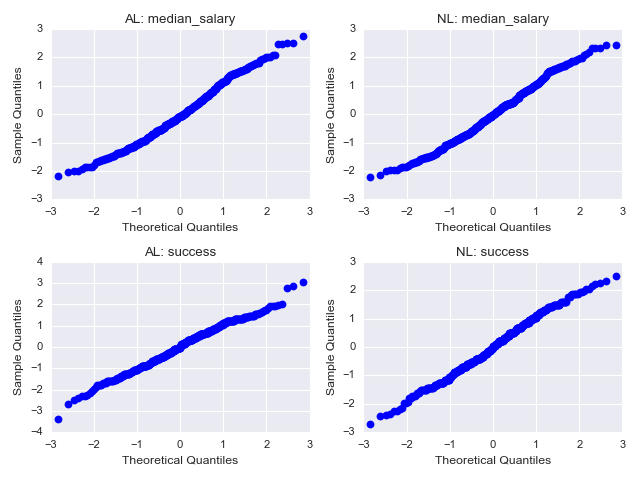

In [14]:
by_lgID = df_q1.groupby('lgID')


gs = gridspec.GridSpec(2, 2)

ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])
ax3 = plt.subplot(gs[2])
ax4 = plt.subplot(gs[3])

sm.graphics.qqplot(by_lgID.get_group('AL')['(log) median_salary'], fit=True, ax=ax1)
sm.graphics.qqplot(by_lgID.get_group('NL')['(log) median_salary'], fit=True, ax=ax2)
sm.graphics.qqplot(by_lgID.get_group('AL')['success'], fit=True, ax=ax3)
sm.graphics.qqplot(by_lgID.get_group('NL')['success'], fit=True, ax=ax4)

ax1.title.set_text('AL: median_salary')
ax2.title.set_text('NL: median_salary')
ax3.title.set_text('AL: success')
ax4.title.set_text('NL: success')

plt.tight_layout()

plt.show()

<IPython.core.display.Javascript object>


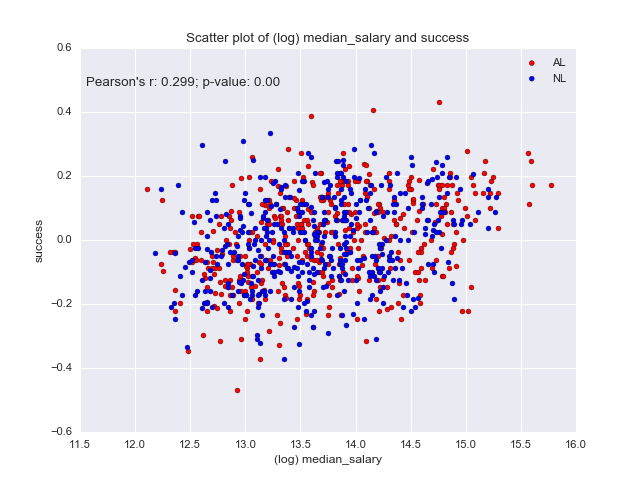

In [15]:
df_q1['(log) median_salary'] = df_q1['median_salary'].apply(np.log)

ax = by_lgID.get_group('AL').plot.scatter(x='(log) median_salary', y='success', color='Red', label='AL')

by_lgID.get_group('NL').plot.scatter(x='(log) median_salary', y='success', color='Blue', label='NL', ax=ax)


r = stats.pearsonr(df_q1['(log) median_salary'], df_q1['success'])

plt.figtext(
    x=0.135, 
    y=0.82, 
    s='Pearson\'s r: {0}; p-value: {1:.2f}'.format(round(r[0], 3), r[1])
)

plt.title('Scatter plot of (log) median_salary and success')

Do those who win at least one playoff round spend more on salary than the rest?

In [18]:
def q_map(quantiles, salary):
    if salary <= quantiles.iloc[0]:
        return 4
    if (salary <= quantiles.iloc[1]) and (salary > quantiles.iloc[0]):
        return 3
    if (salary <= quantiles.iloc[2]) and (salary > quantiles.iloc[1]):
        return 2
    if (salary <= quantiles.iloc[3]) and (salary > quantiles.iloc[2]):
        return 1

quantiles = [i/4 for i in range(1, 5)]    

df_q1['quartile'] = data['median_salary'].apply(
    lambda x: q_map(data['median_salary'].quantile(quantiles), salary=x))

stats.wilcoxon(x=df_q1['Rank'], y=df_q1['quartile'], correction=False)

WilcoxonResult(statistic=62526.5, pvalue=5.3816629579052018e-28)

WilcoxonResult(statistic=92266.0, pvalue=4.1850199195901586e-17)

#### Postseason success

In [27]:
df_q2 = data[[col for col in data.columns if col not in ['G', 'W', 'L', 'WCWin']]]

#### Is the median salary of wildcard winners less than the median playoff salary

#### Salary expenditure vs success over time

In [ ]:
data['median_salary'].apply(lambda x: "${:,}".format(round(x, 2)))

In [35]:
def heatmap(pvt_tbl, values, cmap, null_color='white'):
    hm = pvt_tbl.style\
                .background_gradient(cmap, axis=1)\
                .set_properties(**{'max-width': '80px', 'font-size': '1pt'})\
                .set_caption(values + " (Hover to magnify)")\
                .set_precision(2)\
                .set_table_styles(
                    [dict(selector="th", props=[("font-size", "4pt")]),
                     dict(selector="td", props=[('padding', "0em 0em")]),
                     dict(selector="th:hover", props=[("font-size", "12pt")]),
                     dict(selector="tr:hover td:hover", props=[('max-width', '200px'), ('font-size', '12pt')])]
                )\
                .highlight_null(null_color=null_color)
    return hm